In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Graph_Neural_Network')

In [3]:
!pip install torch_geometric==2.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.1 MB/s eta 0:00:00


In [6]:
import torch_geometric
from torch_geometric.data import Data
import numpy as np
import torch
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
import torch.nn.functional as F
import os

# 1.加载数据 Loading Elliptic dataset

df_classes = pd.read_csv('./data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
df_edges = pd.read_csv('./data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
df_features = pd.read_csv('./data/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)

# 删除 unknown 类别，仅保留合法/非法交易（1/2）
df_classes = df_classes[df_classes['class'] != 'unknown']
df_classes['class'] = df_classes['class'].map({'1': 1, '2': 0})  # 1: illicit, 0: licit

# 合并特征与类别标签
df_merge = df_features.merge(df_classes, how='inner', right_on="txId", left_on=0)
df_merge = df_merge.drop(['txId'], axis=1)

In [7]:
# 2.图构建
nodes = df_merge[0].values
map_id = {j: i for i, j in enumerate(nodes)}

edges = df_edges[df_edges.txId1.isin(map_id) & df_edges.txId2.isin(map_id)].copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)
edge_index = torch.tensor(edges.values.T, dtype=torch.long).contiguous()
edge_weights = torch.ones(edge_index.shape[1], dtype=torch.float32)

In [8]:
# 3.节点特征与标签
labels = torch.tensor(df_merge['class'].values, dtype=torch.float32)
node_features = torch.tensor(np.array(df_merge.drop([0, 'class', 1], axis=1).values), dtype=torch.float32)

# 时间步信息
time_steps = torch.tensor(df_merge[1].values, dtype=torch.long)

# 构建 PyG 数据对象
elliptic_dataset = Data(x=node_features, edge_index=edge_index, edge_weights=edge_weights, y=labels)
elliptic_dataset.time_step = time_steps

# 4.时间序列划分
# 前35步为训练集，36–49步为测试集
train_mask = (elliptic_dataset.time_step <= 35)
test_mask = (elliptic_dataset.time_step > 35)

elliptic_dataset.train_idx = train_mask.nonzero(as_tuple=True)[0]
elliptic_dataset.test_idx = test_mask.nonzero(as_tuple=True)[0]

print(f"Train nodes: {len(elliptic_dataset.train_idx)}, Test nodes: {len(elliptic_dataset.test_idx)}")
print(f"Train time steps: {elliptic_dataset.time_step[elliptic_dataset.train_idx].unique().tolist()}")
print(f"Test time steps: {elliptic_dataset.time_step[elliptic_dataset.test_idx].unique().tolist()}")


Train nodes: 31235, Test nodes: 15329
Train time steps: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
Test time steps: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [9]:
# 5.模型定义
class TGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, K=3):
        super().__init__()
        self.norm1 = torch.nn.BatchNorm1d(dim_in)
        self.conv1 = torch_geometric.nn.TAGConv(dim_in, dim_h, K)
        self.norm2 = torch.nn.BatchNorm1d(dim_h)
        self.conv2 = torch_geometric.nn.TAGConv(dim_h, dim_out, K)

    def forward(self, x, edge_index):
        h = self.norm1(x)
        h = self.conv1(h, edge_index)
        h = self.norm2(h)
        h = F.leaky_relu(h)
        out = self.conv2(h, edge_index)
        return out


def accuracy(y_pred, y_true, threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > threshold).float()
    correct = (y_pred_label == y_true).float().sum()
    return correct / y_true.shape[0]

In [10]:
# 6.训练与测试函数
def train(model, data, optimizer, criterion, num_epochs, checkpoint_dir):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} | Train Loss: {loss:.4f} | Train Acc: {acc*100:.2f}%")
            if loss < best_val_loss:
                best_val_loss = loss
                torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_temporal_model.pt"))
                print("✓ Saved new best model")

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    preds = (torch.sigmoid(out) > 0.5).float().squeeze(1)
    y_true = data.y[data.test_idx]
    y_pred = preds[data.test_idx]
    return y_true.cpu().numpy(), y_pred.cpu().numpy()

In [11]:
# 7.实验超参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = 165
hidden_dim = 150
output_dim = 1
learning_rate = 0.005
weight_decay = 1e-5
num_epochs = 200

model = TGNN(input_dim, hidden_dim, output_dim, K=3).to(device)
data = elliptic_dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.BCEWithLogitsLoss()

Epoch 000 | Train Loss: 1.0518 | Train Acc: 39.32%
✓ Saved new best model
Epoch 010 | Train Loss: 0.2297 | Train Acc: 89.35%
✓ Saved new best model
Epoch 020 | Train Loss: 0.1773 | Train Acc: 89.67%
✓ Saved new best model
Epoch 030 | Train Loss: 0.1558 | Train Acc: 94.83%
✓ Saved new best model
Epoch 040 | Train Loss: 0.1391 | Train Acc: 96.21%
✓ Saved new best model
Epoch 050 | Train Loss: 0.1220 | Train Acc: 96.58%
✓ Saved new best model
Epoch 060 | Train Loss: 0.1077 | Train Acc: 96.75%
✓ Saved new best model
Epoch 070 | Train Loss: 0.0972 | Train Acc: 96.99%
✓ Saved new best model
Epoch 080 | Train Loss: 0.0894 | Train Acc: 97.22%
✓ Saved new best model
Epoch 090 | Train Loss: 0.0833 | Train Acc: 97.42%
✓ Saved new best model
Epoch 100 | Train Loss: 0.0783 | Train Acc: 97.60%
✓ Saved new best model
Epoch 110 | Train Loss: 0.0740 | Train Acc: 97.73%
✓ Saved new best model
Epoch 120 | Train Loss: 0.0701 | Train Acc: 97.85%
✓ Saved new best model
Epoch 130 | Train Loss: 0.0665 | Train

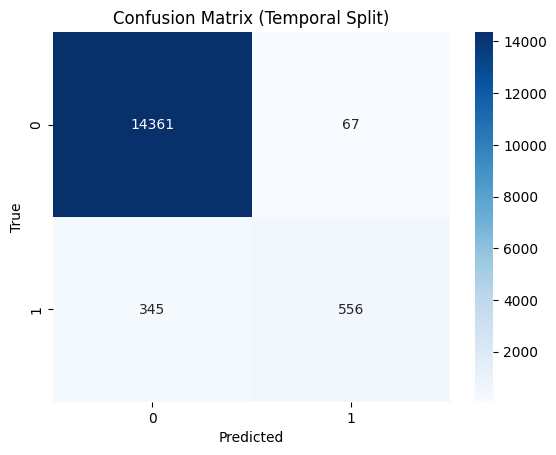

In [12]:
# 8.模型训练
train(model, data, optimizer, criterion, num_epochs, './result/models_temporal')

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 10.模型测试
model.load_state_dict(torch.load('./result/models_temporal/best_temporal_model.pt'))
y_true, y_pred = test(model, data)

print("\n=== Classification Report (Temporal Split) ===")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Temporal Split)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
# ====================== 模型测试与多指标评估 ======================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# 加载最优模型
model.load_state_dict(torch.load('./result/models_temporal/best_temporal_model.pt'))
model.eval()

with torch.no_grad():
    out = model(data.x, data.edge_index)
    prob = torch.sigmoid(out[data.test_idx]).squeeze().cpu().numpy()
    y_pred = (prob > 0.5).astype(int)
    y_true = data.y[data.test_idx].cpu().numpy().astype(int)

# 计算多项指标
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print("\n=== Temporal Split Evaluation Metrics ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")


=== Temporal Split Evaluation Metrics ===
Accuracy:  0.9731
Precision: 0.8925
Recall:    0.6171
F1-score:  0.7297
MCC:       0.7295
